<a href="https://colab.research.google.com/github/sanjeevr5/NLP_Colab_Exercises/blob/main/1.%20NLP_Feature_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Feature Engineering Techniques For NLP (English)
<pre>
<b> Data Used : </b> SST-5 Fine grained movie sentimental analysis by Stanford
<b> 1. Strongly Negative 2. Weakly Negative 3. Neutral 4. Weakly Positive 5. Strongly Positive
<b> Special thanks to https://github.com/prrao87/fine-grained-sentiment/tree/master/data/sst for the processed data </b>
<b> Notebook authored by : Sanjeev Ram </b>
 We shall try to implement different techniques of data exploration from the train data alone
 <i>Orginal Dataset : https://nlp.stanford.edu/sentiment/</i>
 <b> This notebook will be updated as I find interesting text feature engineering techniques. Feature selection techniques are implemented in a separate notebook</b>
</pre>


## 1.1 Dataset Loading

In [1]:
# Since the datasize is small we shall use list for quicker accessibility
import re
import pandas as pd
import spacy
import nltk
nltk.download('words')
from nltk.corpus import words
setofwords = set(words.words())

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [3]:
def get_sentences(path):
  data = []
  with open(path, 'r') as f:
    for line in f.readlines():
      data.append(line.split('\t'))
  return pd.DataFrame(data, columns = ['Label', 'Review'])
train_sentences = get_sentences('/content/train.txt')

## 1.2 Data Exploration

In [4]:
train_sentences.head()

,Label,Review
0,__label__4,The Rock is destined to be the 21st Century 's...
1,__label__5,The gorgeously elaborate continuation of `` Th...
2,__label__4,Singer/composer Bryan Adams contributes a slew...
3,__label__3,You 'd think by now America would have had eno...
4,__label__4,Yet the act is still charming here .\n


<b>1. What is the shape of the dataframe that is the number of rows and columns?</b>

In [5]:
shape = train_sentences.shape
print(f'The shape of the dataset is {shape[0]} rows and {shape[1]} columns')

The shape of the dataset is 8544 rows and 2 columns


<b>2. Convert all the labels to numeric representations</b><br>
Since machines can only interpret numbers

In [6]:
train_sentences.Label = train_sentences.Label.map(lambda x : int(re.sub(r'[^\d]', '', str(x)).strip()))

In [7]:
train_sentences.head()

,Label,Review
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .\n


<b>3. Do we have null values in the dataset? </b><br>

In [8]:
train_sentences.isnull().sum(axis = 0)

Label     0
Review    0
dtype: int64

The data does not have any null values

<b>4. Do we have a balanced dataset? </b><br>

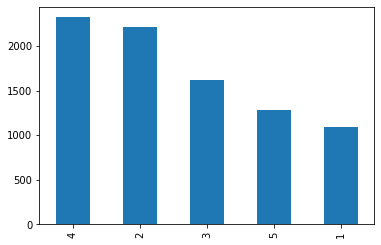

In [9]:
train_sentences.Label.value_counts().plot(kind = 'bar')

- We dont have a balanced dataset 
- Weakly positive and weakly negative are dominating while strong negative being the lowest

## 1.3 Feature Engineering

<b>1. Do we have special characters/ Punctuation marks in the reviews?</b>
Yes, we have some punctuation marks and special characters are due to the encoding

<b>2. Hypothesis  : Long reviews are generally good reviews </b> (We can use this as a feature engineering technique)
- Split using white space 
- Assuming that data is clean

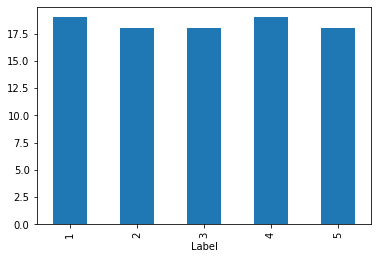

In [10]:
train_sentences['Review_Length'] = train_sentences.Review.map(lambda r: len(r.split()))
train_sentences.groupby('Label')['Review_Length'].median().plot(kind = 'bar')

- All reviews almost have the same length

<b>3. Under which label do we have very short reviews </b>
- Split using white space 
- Assuming that data is clean

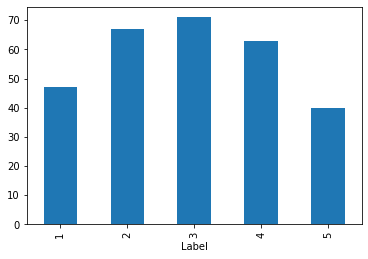

In [11]:
train_sentences['Very_short_review'] = train_sentences.Review.map(lambda r: 1 if len(r.split()) <= 4 else 0)
train_sentences.groupby('Label')['Very_short_review'].sum().plot(kind = 'bar')

- This is not so convincing this is might reduce the discriminating power

<b> 4. Feature Engineering :
<li> How many sentences are there in the review?
<li> How many characters are there in the review without cleaning?
<li> How many words are there in the review without cleaning? Assuming that whitepsace split is optimal
<li> How many words are repeated in the review?
<li> How many "English" words not in the NLTK dictionary are used?
<li> How many stop words are used using "Spacy"?
<li> How expressive is the review? "Use of punctuation marks"
<li> How many names are mentioned in the review? Eg. Arnold


In [12]:
def explore(series):
  data = []
  for reviews in series:
    sent_ct, char_ct, word_ct, rep_wd_ct, fancy_wd_ct, noun_ct, stop_wd_ct, person_name_ct, punct_ct = 0, 0, 0, 0, 0, 0, 0, 0, 0
    doc = nlp(reviews)
    for sent in doc.sents:
      sent = sent.text
      sent_ct += 1
      char_ct += len(sent)
      word_ct += len(sent.split())
      rep_wd_ct += len(sent.split()) - len(set(sent.split()))
      for token in nlp(sent):
        if token.text not in setofwords:
          fancy_wd_ct += 1
        if token.pos_ == 'NOUN':
          noun_ct += 1
        if token.is_stop:
          stop_wd_ct += 1
        if token.tag_ == 'PERSON':
          person_name_ct += 1
        if token.is_punct:
          punct_ct += 1  
    data.append((sent_ct, char_ct, word_ct, rep_wd_ct, fancy_wd_ct, noun_ct, stop_wd_ct, person_name_ct, punct_ct))
  return pd.DataFrame(data, columns = ['sent_ct', 'char_ct', 'word_ct', 'rep_wd_ct', 'fancy_wd_ct', 'noun_ct', 'stop_wd_ct', 'person_name_ct', 'punct_ct'])

In [13]:
before_processing = pd.concat([train_sentences[['Review', 'Label']], explore(train_sentences.Review)], axis = 1) 

<b> 5. Let's see the discriminative power of our features </b>

<b> 5.1 Sentence Count

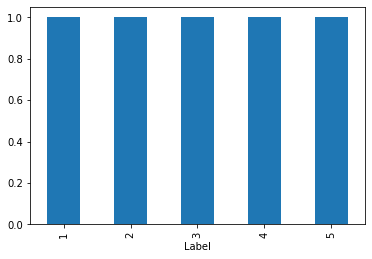

In [14]:
before_processing.groupby('Label')['sent_ct'].median().plot(kind = 'bar')

- All reviews are almost a single sentence

<b> 5.2 Character Count

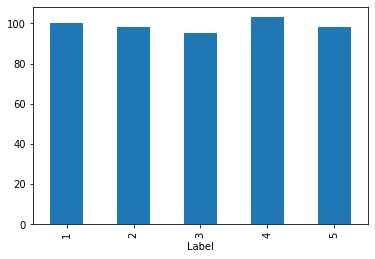

In [15]:
before_processing.groupby('Label')['char_ct'].median().plot(kind = 'bar')

- Looks like weakly positive has the highest (median) character count. This may be due to the fact that people are expressive

<b> 5.3 Repeated Word Count

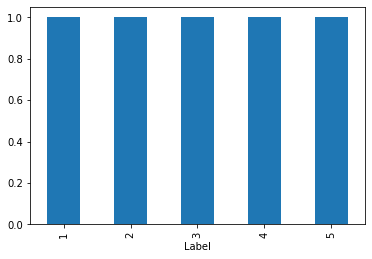

In [16]:
before_processing.groupby('Label')['rep_wd_ct'].median().plot(kind = 'bar')

- Words are not repeated much in the reviews

<b> 5.4 Words Not Present in NLTK Dictionary

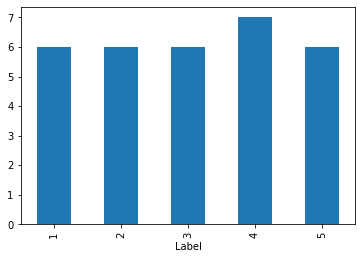

In [18]:
before_processing.groupby('Label')['fancy_wd_ct'].median().plot(kind = 'bar')

- Weakly positive class has more words which are not present in the NLTK dictionary

<b> 5.5 Noun Count

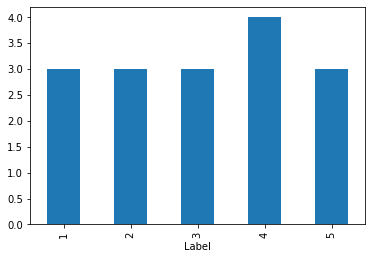

In [19]:
before_processing.groupby('Label')['noun_ct'].median().plot(kind = 'bar')

<b> 5.6 Predefined set of stopwords count

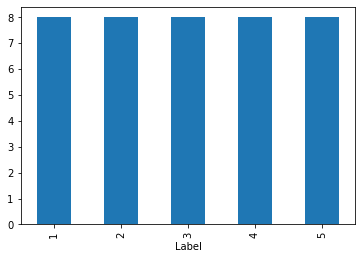

In [20]:
before_processing.groupby('Label')['stop_wd_ct'].median().plot(kind = 'bar')

- This is not a good discriminator

<b> 5.7 Punctuation Count

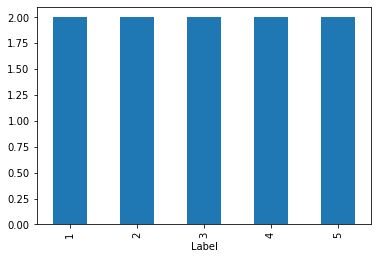

In [22]:
before_processing.groupby('Label')['punct_ct'].median().plot(kind = 'bar')

# 1.4 Conclusion

- NER can be a powerful technique for discrimination. For eg. All Chris Nolan movies are blockbusters and hence identifying names in the reviews might increase the discriminating power but unfortunately we could not identify any movie cast names
